In [80]:
# Import the libraries that we will need in this project
import pandas as pd
import datetime as dt
import numpy as np
import requests
import tweepy
import json
import re
import time
from nltk import pos_tag

# Gathering Data
## Type of Data:

### (1) CSV
### (2) download from website
### (3) Twitter API's JSON data


## Gathering Data - Twitter Archive (.csv)


In [81]:
# Read the twitter-archive-enhanced.csv file and store it as dataframe in archive
archive = pd.read_csv('twitter-archive-enhanced.csv', encoding = 'utf-8')
# Quick check to the file content and structure
archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


# Gathering Data - Image Predictions (.tsv)

In [82]:
# Using Requests library to download a file then store it in a tsv file
import requests
import pandas as pd
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

#print(response.content)
#print(url.split('/')[-1])

with open(url.split('/')[-1], mode = 'wb') as outfile:
    outfile.write(response.content)

# Read the downloaded file into a dataframe 'images'
images = pd.read_csv('image-predictions.tsv', sep = '\t', encoding = 'utf-8')
# Quick check to the file content and structure
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


# Gathering Data - Twitter Data

In [83]:
# Autontification to twitter API

# Generate your own at https://apps.twitter.com/app
# CONSUMER_KEY = 'Consumer Key (API key)'
# CONSUMER_SECRET = 'Consumer Secret (API Secret)'
# OAUTH_TOKEN = 'Access Token'
# OAUTH_TOKEN_SECRET = 'Access Token Secret'

consumer_key = '7zBWznG6qyjSrrWWIcL1AfNZm'
consumer_secret = 'kXWuKSLinQ2lDoji0CTaGLmLHCtdRh6mF0jNxCzLthVOg7XsLO'
access_token = '1055581525524209664-LDUJp0GJdpFc13kqACu24sRyOjzJP9'
access_token_secret = '6ICuLcNIG3mUbrxpjCdIca50ttS7PHQVkH85aEtRheHCF'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Construct the API instance
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), # Parse the result to Json Object
                 wait_on_rate_limit = True, # Automatically wait for rate limits to replenish
                 wait_on_rate_limit_notify = True) # Print a notification when Tweepy is waiting for rate limits to replenish

In [84]:
# List of dictionaries to build and convert to a DataFrame later
df_list = []
error_list = []

# Calculate the time of excution
start = time.time()

# Get the tweet object for all the teweets in archive dataframe 
for tweet_id in archive['tweet_id']:
    try:
        page = api.get_status(tweet_id, tweet_mode = 'extended')
             
        favorites = page['favorite_count'] # How many favorites the tweet had
        retweets = page['retweet_count'] # Count of the retweet
        user_followers = page['user']['followers_count'] # How many followers the user had
        user_favourites = page['user']['favourites_count'] # How many favorites the user had
        date_time = page['created_at'] # The date and time of the creation
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    
    # Not best practice to catch all exceptions but fine for this short script
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)

# Calculate the time of excution
end = time.time()
print(end - start)
# 8888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 837012587749474308 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# Rate limit reached. Sleeping for: 714
# 827228250799742977 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 802247111496568832 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 775096608509886464 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 770743923962707968 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# 754011816964026368 _ [{'code': 144, 'message': 'No status found with that ID.'}]
# Rate limit reached. Sleeping for: 733
# Rate limit reached. Sleeping for: 736
# 2631.0154485702515

888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]
837012587749474308 _ [{'code': 144, 'message': 'No status found with that ID.'}]
827228250799742977 _ [{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832 _ [{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464 _ [{'code': 144, 'message': 'No status found with that ID.'}]
770743923962707968 _ [{'code

In [85]:
# lengh of the result
print("The lengh of the result", len(df_list))
# The tweet_id of the errors
print("The lengh of the errors", len(error_list))

dataframe_df_list = pd.DataFrame(df_list)
dataframe_df_list.to_csv('dataframe_df_list.csv')

dataframe_error_list = pd.DataFrame(error_list)
dataframe_error_list.to_csv('dataframe_error_list.csv')

The lengh of the result 2342
The lengh of the errors 14


In [86]:
#df_list = pd.read_csv('dataframe_df_list.csv', encoding = 'utf-8')
#error_list = pd.read_csv('dataframe_error_list.csv', encoding = 'utf-8')

In [87]:
# repeat the same process for tweet_ids that we coudln't get and append the result to df_list
ee_list = []
for e in error_list:
    try:
        favorites = page['favorite_count']
        retweets = page['retweet_count']
        user_followers = page['user']['followers_count']
        user_favourites = page['user']['favourites_count']
        date_time = page['created_at']
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
        
    except Exception:
        print(str(tweet_id)+ " _ " + str(e))
        ee_list.append(e)

In [88]:
# We can see that now the 7 errors saved in the list
# lengh of the result
print("The lengh of the result after Querying the errors separately", len(df_list))

The lengh of the result after Querying the errors separately 2356


In [89]:
# Create DataFrames from list of dictionaries
json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers', 'user_favourites', 'date_time'])

# Save the dataFrame in file
json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [90]:
# Read the saved tweet_json.txt file into a dataframe
json_tweets = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
json_tweets.head()

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,38180,8360,7478599,140165,2017-08-01 16:23:56
1,892177421306343426,32743,6176,7478599,140165,2017-08-01 00:17:27
2,891815181378084864,24654,4086,7478599,140165,2017-07-31 00:18:03
3,891689557279858688,41510,8504,7478599,140165,2017-07-30 15:58:51
4,891327558926688256,39693,9199,7478599,140165,2017-07-29 16:00:24


## Gathering Data Summary:
- obtainig data from file `twitter-archive-enhanced.csv` and reading from csv file using pandas
- downloading from internet file `image-predictions.tsv` and downloading file using requests
- Querying an API (`tweet_json.txt`) and get JSON object of all the tweet_ids using Tweepy
- importing all data into Jupyter notebook

# Assessment:
#### After gathering data from all sources, we need to assess the data for quality and tidiness for the following datasets
- `json_tweets` which has retweet and favorite counts
- `images` has the results of a neural network trying to identify dog breed in a tweet's picture
- `archive` has the tweet's text, rating, and dog category



## Assessment - Archive Data

In [91]:
# assessing by visual assessment
archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
182,856602993587888130,NaN,NaN,2017-04-24 20:17:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Luna. It's her first ti...,8.447048e+17,4.196984e+09,2017-03-23 00:18:10 +0000,https://twitter.com/dog_rates/status/844704788...,13,10,Luna,None,None,None,None
1461,694925794720792577,NaN,NaN,2016-02-03 16:49:55 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Please only send in dogs. This t-rex is very s...,NaN,NaN,NaN,https://vine.co/v/iJvUqWQ166L,5,10,None,None,None,None,None
1076,739606147276148736,NaN,NaN,2016-06-05 23:53:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Benji. He just turned 1. Has already give...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739606147...,9,10,Benji,None,None,pupper,None
1479,693582294167244802,6.935722e+17,1.198989e+09,2016-01-30 23:51:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Personally I'd give him an 11/10. Not sure why...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
1151,725842289046749185,NaN,NaN,2016-04-29 00:21:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Colby. He's currently regretting all t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/725842289...,12,10,Colby,None,None,None,None
2267,667524857454854144,NaN,NaN,2015-11-20 02:08:22 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Another topnotch dog. His name is Big Jumpy Ra...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667524857...,12,10,None,None,None,None,None
2079,670826280409919488,NaN,NaN,2015-11-29 04:47:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Scary dog here. Too many legs. Extra tail. Not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670826280...,2,10,None,None,None,None,None
685,788150585577050112,NaN,NaN,2016-10-17 22:51:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Leo. He's a golden chow. Rather h*ckin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/788150585...,13,10,Leo,None,None,None,None
499,813127251579564032,NaN,NaN,2016-12-25 21:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's an anonymous doggo that appears to be v...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813127251...,11,10,None,doggo,None,None,None
280,839549326359670784,NaN,NaN,2017-03-08 18:52:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winston. He knows he's a little too big f...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/839549326...,12,10,Winston,None,None,None,None


In [92]:
# assessing by programmatic assessment
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [93]:
# assessing by programmatic assessment
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [94]:
# finding duplicates
archive[archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [95]:
archive.tweet_id.duplicated().value_counts()

False    2356
Name: tweet_id, dtype: int64

In [96]:
archive.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [97]:
archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [98]:
archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [99]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [100]:
ratings = archive['text'].str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

In [101]:
ratings[0].value_counts()

12       558
11       464
10       461
13       351
9        158
8        102
14        54
7         54
5         35
6         32
3         19
4         17
2          9
1          9
15         2
0          2
420        2
9.75       2
11.26      1
143        1
960        1
204        1
99         1
44         1
17         1
1776       1
13.5       1
121        1
50         1
9.5        1
84         1
182        1
20         1
666        1
11.27      1
80         1
144        1
60         1
88         1
24         1
45         1
007        1
165        1
Name: 0, dtype: int64

In [102]:
archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [103]:
# finding dog type NOne for all
df_dog_type = archive[(archive['doggo']=='None')& (archive['floofer']=='None') & (archive['pupper']=='None')&(archive['puppo']=='None')]
df_dog_type


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
10,890006608113172480,NaN,NaN,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,None,None,None,None


In [104]:
# checking multiple dog stages for single tweet id
archive.loc[(archive[['doggo', 'floofer', 'pupper', 'puppo']] != 'None'
                 ).sum(axis=1) > 1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None


In [105]:
archive.name.value_counts().head(5)
archive[archive['tweet_id'] == 733109485275860992]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1113,733109485275860992,NaN,NaN,2016-05-19 01:38:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like father (doggo), like son (pupper). Both 1...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None


In [106]:
#missing url
archive[archive['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


## Assessment - Images data

In [107]:
# assessing visually
images.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
546,677328882937298944,https://pbs.twimg.com/media/CWZbBlAUsAAjRg5.jpg,1,water_buffalo,0.424250,False,kelpie,0.029054,True,Staffordshire_bullterrier,0.028470,True
358,672614745925664768,https://pbs.twimg.com/media/CVWbitUW4AAzclx.jpg,1,starfish,0.712717,False,goldfish,0.258865,False,sea_cucumber,0.002015,False
498,675820929667219457,https://pbs.twimg.com/media/CWD_jQMWEAAdYwH.jpg,1,basset,0.556373,True,beagle,0.201675,True,bloodhound,0.110848,True
1503,784826020293709826,https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg,1,chow,0.090341,True,binoculars,0.083499,False,Irish_setter,0.077456,True
925,702539513671897089,https://pbs.twimg.com/media/Cb_r8qTUsAASgdF.jpg,3,Pomeranian,0.714367,True,Shih-Tzu,0.040574,True,silky_terrier,0.032511,True


In [108]:
#assessing programmatically
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [109]:
images.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [110]:
images[images['tweet_id'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [111]:
images.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [112]:
images['jpg_url'].duplicated().value_counts()

False    2009
True       66
Name: jpg_url, dtype: int64

In [113]:
images[images['jpg_url']=='https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
591,679158373988876288,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.25153,True,bath_towel,0.116806,False
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.25153,True,bath_towel,0.116806,False


# Assessment - tweets Data

In [114]:
#assessing visually
json_tweets.sample()

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
1122,728387165835677696,3842,1023,7478621,140165,2016-05-06 00:53:27


In [115]:
#assessing programmatically
json_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
tweet_id           2356 non-null int64
favorites          2356 non-null int64
retweets           2356 non-null int64
user_followers     2356 non-null int64
user_favourites    2356 non-null int64
date_time          2356 non-null object
dtypes: int64(5), object(1)
memory usage: 110.5+ KB


In [116]:
json_tweets.describe()

,tweet_id,favorites,retweets,user_followers,user_favourites
count,2.356000e+03,2356.000000,2356.000000,2.356000e+03,2356.000000
mean,7.417684e+17,7959.154499,2932.428693,7.478607e+06,140165.062818
std,6.837209e+16,12341.071972,4945.015603,8.057232e+01,0.497426
min,6.660209e+17,0.000000,0.000000,7.478558e+06,140165.000000
25%,6.776996e+17,1399.500000,583.000000,7.478598e+06,140165.000000
50%,7.178159e+17,3461.500000,1365.000000,7.478601e+06,140165.000000
75%,7.986755e+17,9774.000000,3415.750000,7.478619e+06,140165.000000
max,8.924206e+17,164808.000000,83990.000000,7.479237e+06,140169.000000


In [117]:
json_tweets[json_tweets['tweet_id'].duplicated()]

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
2342,666020888022790149,2538,507,7478559,140165,2015-11-15 22:32:08
2343,666020888022790149,2538,507,7478559,140165,2015-11-15 22:32:08
2344,666020888022790149,2538,507,7478559,140165,2015-11-15 22:32:08
2345,666020888022790149,2538,507,7478559,140165,2015-11-15 22:32:08
2346,666020888022790149,2538,507,7478559,140165,2015-11-15 22:32:08
2347,666020888022790149,2538,507,7478559,140165,2015-11-15 22:32:08
2348,666020888022790149,2538,507,7478559,140165,2015-11-15 22:32:08
2349,666020888022790149,2538,507,7478559,140165,2015-11-15 22:32:08
2350,666020888022790149,2538,507,7478559,140165,2015-11-15 22:32:08
2351,666020888022790149,2538,507,7478559,140165,2015-11-15 22:32:08


In [118]:
json_tweets['tweet_id'].duplicated().value_counts()

False    2342
True       14
Name: tweet_id, dtype: int64

In [119]:
# combine all data columns to find tidiness of data -programmatic assessment
all_columns = pd.Series(list(json_tweets) + list(archive) + list(images))
all_columns[all_columns.duplicated()]


6     tweet_id
23    tweet_id
dtype: object

In [120]:
list(all_columns)

['tweet_id',
 'favorites',
 'retweets',
 'user_followers',
 'user_favourites',
 'date_time',
 'tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

# Assessing Data Summary

### archive dataset:

- misssing data in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id,retweeted_status_timestamp, expanded_urls 
- timestamp, retweeted_status_timestamp are object instead of datetime
- some dog names are invalid names such as ’None’, ‘a’ a, an, the, just, one, very, quite, not, actually, mad, space, infuriating, all, officially, 0, old, life, unacceptable, my, incredibly, by, his, such
- few rating_numerator and rating_denominator numbers are very high numbers. For example in tweet_id 832215909146226000 has rating erroneously mentioned 75 as numerator, whereas the text has numerator as 9.75
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be string instead of float
- tweet_id is int instead of string


### Images dataset:
- tweet_id is int instead of string

#### json_tweets dataset:

- 14 tweet_ids are duplicates.
- date_time should be date time format instead of object
- tweet_ids are int instead of string


### Tidiness
- archive dataset has too many dog breed columns. instead it could be one column with dog stage in archive dataset
- tweet_id in other two tables need to be removed when we combine all tables




# Cleaning Data

In [121]:
# copying all datasets before cleaning
archive_clean = archive.copy()
images_clean = images.copy()
json_tweets_clean = json_tweets.copy()

##### Define
- misssing data in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id,retweeted_status_timestamp, expanded_urls
    - for some tweet ids, above variables are NaN. In this project, the available values for the above variables are considered and NaN values are kept as it is.


##### Define
- convert tweet_id into string for all three dataset
- convert timestamp and retweeted_status_timestamp into date time
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be string instead of float
date_time in json_tweets dataset should be datetime

##### Code

In [122]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)
json_tweets_clean.tweet_id = json_tweets_clean.tweet_id.astype(str)
images_clean.tweet_id = images_clean.tweet_id.astype(str)
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(str)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(str)
archive_clean.retweeted_status_id = archive_clean.retweeted_status_id.astype(str)
archive_clean.retweeted_status_user_id = archive_clean.retweeted_status_user_id.astype(str)
json_tweets_clean.date_time = pd.to_datetime(json_tweets_clean.date_time)
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.retweeted_status_timestamp)

##### Test

In [123]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datet

In [124]:
images_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [125]:
json_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
tweet_id           2356 non-null object
favorites          2356 non-null int64
retweets           2356 non-null int64
user_followers     2356 non-null int64
user_favourites    2356 non-null int64
date_time          2356 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 110.5+ KB


##### Define
14 tweet_ids in json_tweets are duplicates

##### code

In [126]:
json_tweets_clean = json_tweets_clean.drop_duplicates(['tweet_id'],keep='last')

##### Test

In [127]:
json_tweets_clean[json_tweets_clean['tweet_id'].duplicated()]

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time


In [128]:
json_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2342 entries, 0 to 2355
Data columns (total 6 columns):
tweet_id           2342 non-null object
favorites          2342 non-null int64
retweets           2342 non-null int64
user_followers     2342 non-null int64
user_favourites    2342 non-null int64
date_time          2342 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 128.1+ KB


##### Define
some dog names are ’None’, ‘a’ a, an, the, just, one, very, quite, not, actually, mad, space, infuriating, all, officially, 0, old, life, unacceptable, my, incredibly, by, his, such

##### Code

In [129]:
non_names = ['a', 'an', 'the', 'just', 'one', 'very', 'quite', 'not', 'actually', 
             'mad', 'space', 'infuriating', 'all', 'officially', '0', 'old', 'life',
             'unacceptable', 'my', 'incredibly', 'by', 'his', 'such']

for name in archive_clean.name:
    if name in non_names:
        archive_clean.name[archive_clean.name == name] = 'None'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


##### Test

In [130]:
archive_clean['name'].value_counts().head(5)

None       850
Charlie     12
Oliver      11
Cooper      11
Lucy        11
Name: name, dtype: int64

##### Define
- few rating_numerator and rating_denominator numbers are very high numbers. For example in tweet_id 832215909146226000 has rating erroneously mentioned 75 as numerator, whereas the text has numerator as 9.75

##### Code

In [131]:
ratings = archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

In [132]:
ratings

,0,1
0,13,10
1,13,10
2,12,10
3,13,10
4,12,10
5,13,10
6,13,10
7,13,10
8,13,10
9,14,10


In [133]:
ratings.columns = ["extracted_numerator", "extracted_denominator"]
ratings["extracted_numerator"]

0       13
1       13
2       12
3       13
4       12
5       13
6       13
7       13
8       13
9       14
10      13
11      13
12      13
13      12
14      13
15      13
16      12
17      13
18      13
19      13
20      12
21      13
22      14
23      13
24      13
25      12
26      13
27      13
28      13
29      12
        ..
2326     2
2327     7
2328     9
2329    11
2330     6
2331     8
2332    10
2333     9
2334     3
2335     1
2336    11
2337    10
2338     1
2339    11
2340     8
2341     9
2342     6
2343    10
2344     9
2345    10
2346     8
2347     9
2348    10
2349     2
2350    10
2351     5
2352     6
2353     9
2354     7
2355     8
Name: extracted_numerator, Length: 2356, dtype: object

In [134]:
ratings.info()
ratings['extracted_numerator']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 2 columns):
extracted_numerator      2356 non-null object
extracted_denominator    2356 non-null object
dtypes: object(2)
memory usage: 36.9+ KB


0       13
1       13
2       12
3       13
4       12
5       13
6       13
7       13
8       13
9       14
10      13
11      13
12      13
13      12
14      13
15      13
16      12
17      13
18      13
19      13
20      12
21      13
22      14
23      13
24      13
25      12
26      13
27      13
28      13
29      12
        ..
2326     2
2327     7
2328     9
2329    11
2330     6
2331     8
2332    10
2333     9
2334     3
2335     1
2336    11
2337    10
2338     1
2339    11
2340     8
2341     9
2342     6
2343    10
2344     9
2345    10
2346     8
2347     9
2348    10
2349     2
2350    10
2351     5
2352     6
2353     9
2354     7
2355     8
Name: extracted_numerator, Length: 2356, dtype: object

In [135]:
archive_clean["extracted_numerator"] = ratings["extracted_numerator"]
archive_clean["extracted_denominator"] = ratings["extracted_denominator"]
new_cols = ['tweet_id','in_reply_to_status_id','in_reply_to_user_id','timestamp','source','text','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls','rating_numerator','rating_denominator','extracted_numerator','extracted_denominator','name','doggo','floofer','pupper','puppo']
archive_clean = archive_clean[new_cols]
archive_clean[archive_clean['tweet_id'] == '786709082849828864']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,extracted_numerator,extracted_denominator,name,doggo,floofer,pupper,puppo
695,786709082849828864,nan,nan,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",nan,nan,NaT,https://twitter.com/dog_rates/status/786709082...,75,10,9.75,10,Logan,None,None,None,None


##### Test

#### Tidiness
too many dog breed columns. instead it could be one column with dog stage in archive dataset

##### Define
too many dog breed columns. instead it could be one column with dog stage in archive dataset

##### Code

In [136]:
archive_clean = pd.melt(archive_clean,
                        id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
                                 'timestamp', 'source', 'text', 'retweeted_status_id',
                                 'retweeted_status_user_id', 'retweeted_status_timestamp',
                                 'expanded_urls', 'rating_numerator', 'rating_denominator', 'extracted_numerator', 'extracted_denominator', 'name'],
                        value_name='dog_stage')
archive_clean = archive_clean.drop('variable', axis=1)
archive_clean['dog_stage'].value_counts()

None       9030
pupper      257
doggo        97
puppo        30
floofer      10
Name: dog_stage, dtype: int64

In [137]:
# Keep one of 3 duplicates with 'None'
dup_df1 = archive_clean.drop_duplicates(subset=['tweet_id', 'dog_stage']) 
dup_df1 = archive_clean.drop_duplicates()

# Keep rows with dog stage
dup_pos = archive_clean.duplicated(subset='tweet_id', keep = False)
dup_df2 = archive_clean[dup_pos]
dup_df2 = dup_df2[dup_df2.dog_stage != 'None']

# Combine
dup_df1 = dup_df1.drop_duplicates(subset = 'tweet_id', keep = False)
dup_df_merged = dup_df1.append(dup_df2)

In [138]:
dup_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2370 entries, 0 to 8151
Data columns (total 16 columns):
tweet_id                      2370 non-null object
in_reply_to_status_id         2370 non-null object
in_reply_to_user_id           2370 non-null object
timestamp                     2370 non-null datetime64[ns]
source                        2370 non-null object
text                          2370 non-null object
retweeted_status_id           2370 non-null object
retweeted_status_user_id      2370 non-null object
retweeted_status_timestamp    183 non-null datetime64[ns]
expanded_urls                 2311 non-null object
rating_numerator              2370 non-null int64
rating_denominator            2370 non-null int64
extracted_numerator           2370 non-null object
extracted_denominator         2370 non-null object
name                          2370 non-null object
dog_stage                     2370 non-null object
dtypes: datetime64[ns](2), int64(2), object(12)
memory usage: 31

In [139]:
remaining_dup_df = dup_df_merged[dup_df_merged.duplicated(subset='tweet_id', keep=False)]
remaining_dup_df[remaining_dup_df.tweet_id == '817777686764523521']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,extracted_numerator,extracted_denominator,name,dog_stage
460,817777686764523521,nan,nan,2017-01-07 16:59:28,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",nan,nan,NaT,https://twitter.com/dog_rates/status/817777686...,13,10,13,10,Dido,doggo
5172,817777686764523521,nan,nan,2017-01-07 16:59:28,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",nan,nan,NaT,https://twitter.com/dog_rates/status/817777686...,13,10,13,10,Dido,pupper


In [140]:
remaining_dup_df.dog_stage = 'multiple'
dup_drops = remaining_dup_df.drop_duplicates()
dup_drops[dup_drops.tweet_id == '817777686764523521']

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,extracted_numerator,extracted_denominator,name,dog_stage
460,817777686764523521,nan,nan,2017-01-07 16:59:28,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",nan,nan,NaT,https://twitter.com/dog_rates/status/817777686...,13,10,13,10,Dido,multiple


In [141]:
duped_ids = set(remaining_dup_df.tweet_id)
duped_ids
for idx in dup_df_merged.tweet_id:
    if idx in duped_ids:
        dup_df_merged.dog_stage[dup_df_merged.tweet_id == idx] = 'multiple'
archive_clean = dup_df_merged.drop_duplicates()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


##### Test

In [142]:
archive_clean.dog_stage.value_counts()

None        1976
pupper       245
doggo         83
puppo         29
multiple      14
floofer        9
Name: dog_stage, dtype: int64

In [143]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 8151
Data columns (total 16 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
extracted_numerator           2356 non-null object
extracted_denominator         2356 non-null object
name                          2356 non-null object
dog_stage                     2356 non-null object
dtypes: datetime64[ns](2), int64(2), object(12)
memory usage: 31

##### Define
- tweet_id in other two tables need to be removed when we combine all tables

##### Code

In [144]:
# merging all data files in to one main file
df_master = pd.merge(archive_clean, images_clean, how = 'left', on = ['tweet_id'] )
df_master_clean = pd.merge(df_master, json_tweets_clean, how = 'left', on = ['tweet_id'])
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 32 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
extracted_numerator           2356 non-null object
extracted_denominator         2356 non-null object
name                          2356 non-null object
dog_stage                     2356 non-null object
jpg_url                       2075 non-null object
img_num      

In [145]:
df_master_clean['user_favourites'].value_counts()

140165.0    2305
140169.0      37
Name: user_favourites, dtype: int64

In [146]:
df_master_clean[df_master['tweet_id'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,retweets,user_followers,user_favourites,date_time


In [147]:
df_master_clean[df_master_clean['tweet_id']=='855851453814013952']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,retweets,user_followers,user_favourites,date_time
1983,855851453814013952,nan,nan,2017-04-22 18:31:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,nan,nan,NaT,https://twitter.com/dog_rates/status/855851453...,...,0.115138,True,groenendael,0.0961,True,46261.0,18309.0,7478598.0,140165.0,2017-04-22 18:31:02


# Storing Data

In [148]:
df_master_clean.to_csv('twitter_images_archive_clean.csv', encoding='utf-8', index=False)

# Analyzing Data

In [149]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns

%matplotlib inline

Text(0.5,1,'Correlation Map')

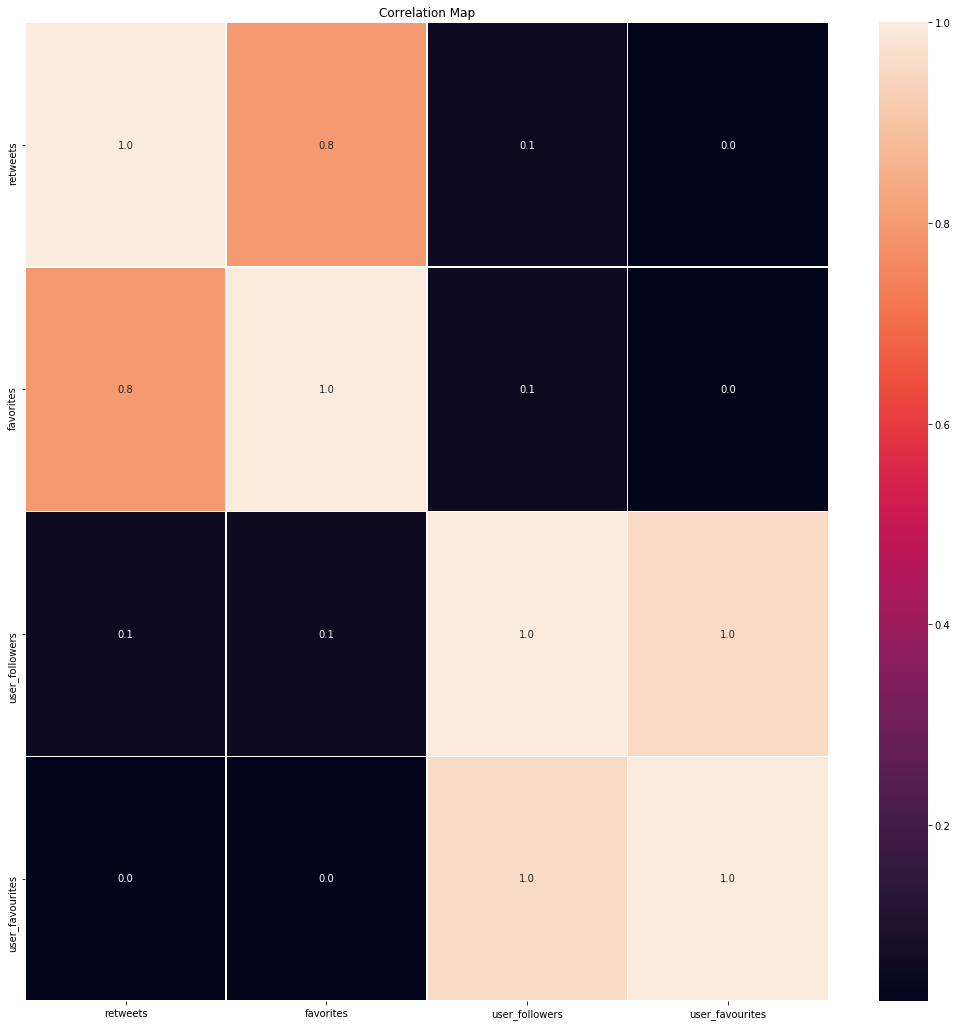

In [150]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_master_clean[['retweets', 'favorites', 'extracted_numerator', 'user_followers', 'user_favourites']].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Map')

Text(0.5,1,'Retweets and favorites Scatter plot')

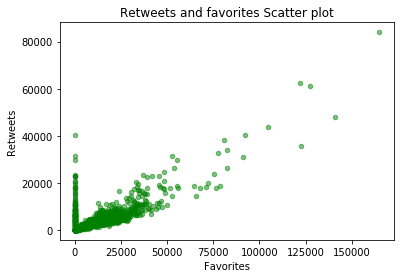

In [151]:
df_master_clean.plot(kind = 'scatter', x = 'favorites', y = 'retweets', alpha = 0.5, color = 'green')
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites Scatter plot')

In [152]:
df_master_clean.info()
# Convert extracted_numerator and extracted_denominator from string to float to plot in graph
df_master_clean['extracted_numerator'] = df_master_clean['extracted_numerator'].astype(float)
df_master_clean['extracted_denominator'] = df_master_clean['extracted_denominator'].astype(float)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 32 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
extracted_numerator           2356 non-null object
extracted_denominator         2356 non-null object
name                          2356 non-null object
dog_stage                     2356 non-null object
jpg_url                       2075 non-null object
img_num      

Text(0,0.5,'Rating')

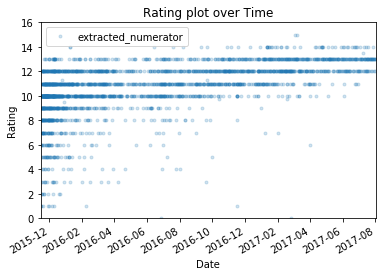

In [153]:

df_master_clean.plot(x = 'timestamp', y ='extracted_numerator', ylim=[0,16], style = '.', alpha = .2)
plt.title('Rating plot over Time')
plt.xlabel('Date')
plt.ylabel('Rating')

In [154]:
df_master_clean['dog_stage'].value_counts()

None        1976
pupper       245
doggo         83
puppo         29
multiple      14
floofer        9
Name: dog_stage, dtype: int64

(-1.3017324392374918,
 1.2200139333869169,
 -1.2099956045726639,
 1.2097099285986213)

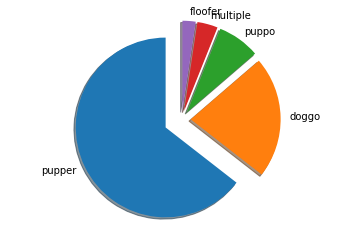

In [155]:
# data partitioned by dog stages

dog_stage_count = list(df_master_clean[df_master_clean['dog_stage'] != 'None']['dog_stage'].value_counts())[0:5]
dog_stages = df_master_clean[df_master_clean['dog_stage'] != 'None']['dog_stage'].value_counts().index.tolist()[0:5]


explode = (0.2, 0.1, 0.1, 0.1,0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(dog_stage_count, explode = explode, labels = dog_stages, shadow = True, startangle = 90)
ax1.axis('equal') 

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0,0.5,'Rating')

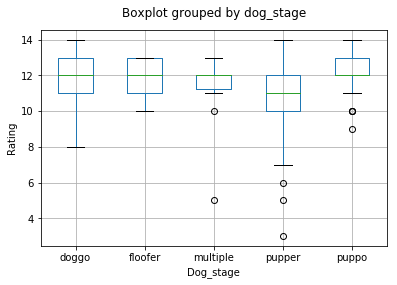

In [156]:
# dog stages with ratings
df_master_clean[df_master_clean['dog_stage'] != 'None'].boxplot(column = ['extracted_numerator'], by = ['dog_stage'])
plt.title('')
plt.xlabel('Dog_stage')
plt.ylabel('Rating')